#  5.1 확률과 언어 모델

# 5.2 RNN이란

# 5.3 RNN 구현

In [1]:
import numpy as np
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.gradds = [np.zerors_like(Wx),np.zerors_like(Wh),np.zerors_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev):
        Wx, Wh, b =self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, df_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next **2)
        db = np.sum(dt, axis = 0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

In [2]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layer = []
        hs = np.empty((N,T,H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype ='f')
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:,t,:] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh = 0
        grads = [0,0,0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx,dh = layer.backward(dhs[:,t,:] + dh)
            dxs[:, t, :] = dx
            
            for i,grad in enumerate(layer.grads):
                grads[i] +=grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

# 5.4 시계열 데이터 처리 계층 구현

# 5.5 RNNLM 학습과 평과

In [3]:
import sys
sys.path.append('..')
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_sie, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D) / 100).astype('f')
        rnn_Wx = (rn(D,H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers =[
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

In [4]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 122

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('말뭉치 크기: %d, 어휘수: %d' %(corpus_size, vocab_size))

max_iters = data_size // (batch_size *time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size -1) // batch_size
offsets = [i *jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype = 'i')
        batch_t = np.empty((batch_size, time_size), dtype = 'i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    ppl = np.exp(total_loss/ loss_count)
    print('| epoch %d | perplexity %.2f' %(epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

말뭉치 크기: 1000, 어휘수: 418
| epoch 1 | perplexity 402.67
| epoch 2 | perplexity 286.97
| epoch 3 | perplexity 226.25
| epoch 4 | perplexity 215.12
| epoch 5 | perplexity 205.81
| epoch 6 | perplexity 202.25
| epoch 7 | perplexity 198.04
| epoch 8 | perplexity 196.35
| epoch 9 | perplexity 191.35
| epoch 10 | perplexity 193.15
| epoch 11 | perplexity 188.95
| epoch 12 | perplexity 191.94
| epoch 13 | perplexity 189.11
| epoch 14 | perplexity 190.26
| epoch 15 | perplexity 190.03
| epoch 16 | perplexity 186.06
| epoch 17 | perplexity 183.72
| epoch 18 | perplexity 181.35
| epoch 19 | perplexity 181.31
| epoch 20 | perplexity 182.29
| epoch 21 | perplexity 180.04
| epoch 22 | perplexity 178.08
| epoch 23 | perplexity 174.12
| epoch 24 | perplexity 176.57
| epoch 25 | perplexity 175.00
| epoch 26 | perplexity 172.18
| epoch 27 | perplexity 168.37
| epoch 28 | perplexity 166.85
| epoch 29 | perplexity 165.20
| epoch 30 | perplexity 158.03
| epoch 31 | perplexity 158.94
| epoch 32 | perplexity 1

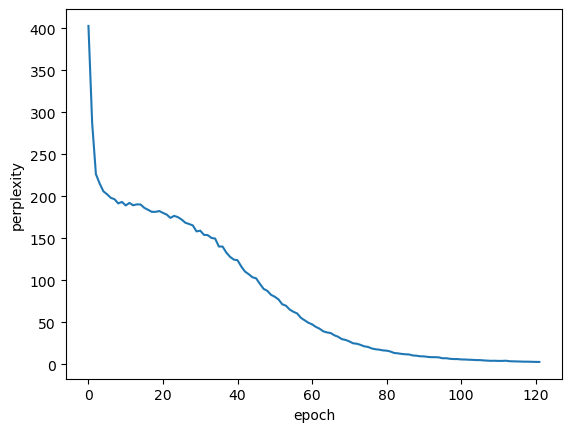

In [5]:
plt.plot(ppl_list, linestyle='-')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.show()